#CPSC 585 Group Project 1
Jeffrey Rhoten, Shayan Darian, Abhinav Singh, Jenny Zhao, Anisha Suresh Mole

#Linear Regression (Machine Learning)

Import libraries

In [ ]:
import numpy as np

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

Import dataset and perform train-test split

In [ ]:
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# Select features related to body mass index and average blood pressure
bmi_idx = diabetes.feature_names.index('bmi')
bp_idx = diabetes.feature_names.index('bp')
X = X[:, [bmi_idx, bp_idx]]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Perform linear regression (ML version)

In [ ]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

Evaluate linear regression ($r^2$)

In [ ]:
# Evaluate linear regression model
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)
print(f"Linear Regression Training R^2: {train_score:.3f}")
print(f"Linear Regression Testing R^2: {test_score:.3f}")

Linear Regression Training R^2: 0.416
Linear Regression Testing R^2: 0.294


Evaluate linear regression (3D plot of data)
Graph the data in 3D space to see if $r^2$ value is reasonable

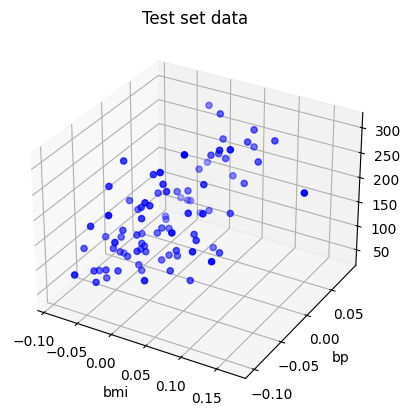

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
X1 = X_test[:, 0]
X2 = X_test[:, 1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, y_test, c='blue', marker='o')
#ax.plot(X_train[:, 0], X_train[:, 1], lin_reg.predict(X_train), color = 'black')
ax.set_xlabel('bmi')
ax.set_ylabel('bp')
ax.set_zlabel('y')
plt.title('Test set data')
plt.show()

And considering the wide spread of the data, a testing $R^2$ of 0.294 seems reasonable

#Linear Regression (Multi-Layer Perceptron)

Import libraries

In [ ]:
#Import statements
import math
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

Helper functions for various mathematical operations

In [ ]:
#Helper functions

# Intitializing weights and biases
def initialize_weight(shape, seed=None):
    if seed is not None:
        random.seed(seed)  # Set seed for reproducibility

    # Calculate the variance of the distribution
    var = 2 / (shape[0] + shape[1])

    # Initialize weights from a normal distribution with zero mean and calculated variance
    weights = []
    for _ in range(shape[0]):
        row = []
        for _ in range(shape[1]):
            # Generate a random number from a normal distribution with mean=0 and variance=var
            rand_num = random.gauss(0, math.sqrt(var))
            row.append(rand_num)
        weights.append(row)

    return weights

# Similar method to initialize the bias
def initialize_bias(shape, seed=None):
    if seed is not None:
        random.seed(seed)  # Set seed for reproducibility

    # Check if shape is a tuple
    if not isinstance(shape, tuple):
        raise TypeError("Shape must be a tuple.")

    # Check if the shape tuple has exactly one element
    if len(shape) != 1:
        raise ValueError("Shape must be a tuple with exactly one element representing the size of the bias vector.")

    # Generate a list representing a vector with random bias values
    bias = [random.uniform(-0.01, 0.01) for _ in range(shape[0])]

    return bias

# Sigmoid activation function
def sigmoid_activation(x):
    if isinstance(x, list):
        return [1 / (1 + math.exp(-val)) for val in x]
    else:
        return 1 / (1 + math.exp(-x))

# Derivative of sigmoid function (will be used in backpropogation)
def sigmoid_derivative(x):
    if isinstance(x, list):
        return [sigmoid_activation(val) * (1 - sigmoid_activation(val)) for val in x]
    else:
        return sigmoid_activation(x) * (1 - sigmoid_activation(x))

# For Matrix Additions
def vector_addition(X, Y):
    if len(X) != len(Y):
        result = []
        for i in range(len(X)):
            if len(Y) == 1:
                result.append(X[i] + Y[0])
            else:
                result.append(X[i] + Y[i])
        return result

# Dot product helper function for the Weights without the use of any libraries
def dot(matrix1, matrix2):
    if isinstance(matrix2[0], list):
        # Matrix multiplication
        result = []
        for i in range(len(matrix2[0])):
            row_result = 0
            for j in range(len(matrix1)):
                row_result += matrix1[j] * matrix2[j][i]
            result.append(row_result)
        return result
    else:
        # Element-wise multiplication
        if len(matrix1) != len(matrix2):
            raise ValueError("Matrices must have the same dimensions for element-wise multiplication")

        result = [matrix1[i] * matrix2[i] for i in range(len(matrix1))]
        return result

def scalar_dot(matrix1, matrix2):
    if isinstance(matrix2[0], list):
        # If matrix2 is a list of lists (matrix)
        if(len(matrix2[0]) == 1):
            result = [[matrix1 * element[0]] for element in matrix2]
        else:
            result = [[matrix1 * element for element in row] for row in matrix2]
    else:
        # If matrix2 is a single list (vector)
        result = [matrix1 * element for element in matrix2]
    return result


def element_wise_multiply(matrix1, matrix2):
    # Check if the matrices have the same dimensions
    if len(matrix1) != len(matrix2):
        raise ValueError("Matrices must have the same dimensions")

    result = []

    # Perform element-wise multiplication
    for i in range(len(matrix1)):
        row_result = []
        row_result = matrix1[i] * matrix2[i]
        result.append(row_result)

    return result


def vector_addition(X, Y):
    # Remember to always pass bias as second parameter
    # Check if the lengths of both vectors are different
    if len(X) != len(Y):
        result = []
        for i in range(len(X)):
            if len(Y) == 1:
                result.append(X[i] + Y[0])
            else:
                result.append(X[i] + Y[i])
        return result

    # Perform element-wise addition
    result = [x + y for x, y in zip(X, Y)]
    return result

# Helper function for transposing a matrix
def transpose(matrix):
    # Check if the input is a list of lists or a single list
    if isinstance(matrix[0], list):
        # Get the number of rows and columns of the original matrix
        rows = len(matrix)
        cols = len(matrix[0])

        # Create a new matrix with dimensions swapped
        transposed_matrix = [[0] * rows for _ in range(cols)]

        # Iterate over the original matrix and fill the transposed matrix
        for i in range(rows):
            for j in range(cols):
                transposed_matrix[j][i] = matrix[i][j]

        return transposed_matrix
    else:
        # If the input is a single list, return its transpose as a list of lists
        return [[val] for val in matrix]

# Helper method to calculate mean of a list of values
def mean(data):
    return sum(data) / len(data)

# Helper method to calculate standard deviation of a list of values
def std(data):
    mu = mean(data)
    variance = sum((x - mu) ** 2 for x in data) / len(data)
    return math.sqrt(variance)

# Helper method to subtract matrices
def substract_matrices(matrix1, matrix2):
    if len(matrix1) != len(matrix2):
      raise ValueError("Matrices must have the same dimensions for element-wise multiplication")
    else:
      for i in range(len(matrix1)):
        if isinstance(matrix2[0], list):
          for j in range(len(matrix1[0])):
            matrix1[i][j] -= matrix2[i][j]
        else:
          matrix1[i] -= matrix2[i]
    return matrix1

Data processing functions

In [ ]:

# Split the data into training and test sets
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        random.seed(random_state)

    # Combining X and y for shuffling
    data = list(zip(X, y))
    random.shuffle(data)

    num_test_samples = int(test_size * len(data))

    # Splitting data into training and test sets
    X_train = [sample[0] for sample in data[num_test_samples:]]
    y_train = [sample[1] for sample in data[num_test_samples:]]
    X_test = [sample[0] for sample in data[:num_test_samples]]
    y_test = [sample[1] for sample in data[:num_test_samples]]

    return X_train, X_test, y_train, y_test

# Normalize the data
def normalize_data(data):
    mu = mean(data)
    sigma = std(data)
    return [(x - mu) / sigma for x in data]

Neural Network related functions

In [ ]:
# Mean Squared Error loss function
def mse_loss(y_true, y_pred):
    return (y_true - y_pred) ** 2

# Derivate of the MSE function (will be used in backpropogation)
def mse_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true)

#Forward propogation
def forward_propagation(X, W1, b1, W2, b2, W3, b3):
    z1_weightedSum = dot(X, W1)
    z1 = vector_addition(z1_weightedSum, b1)
    a1 = sigmoid_activation(z1)
    z2_weightedSum = dot(a1, W2)
    z2 = vector_addition(z2_weightedSum, b2)
    a2 = sigmoid_activation(z2)
    z3_weightedSum = dot(a2, W3)
    z3 = vector_addition(z3_weightedSum, b3)
    y_pred = z3
    cache = (z1, a1, z2, a2)
    return y_pred, cache

#Backpropogation
def backward_propagation(X, y, y_pred, W1, W2, W3, b1, b2, b3, z1, a1, z2, a2):
    # Computing the gradient of the loss with respect to the output layer weighted sum (z3) which is basically y_pred
    dL_dz3 = mse_derivative(y, y_pred)

    # Computing the gradient of the loss with respect to the output layer weights(W3)
    dL_dW3 = scalar_dot(dL_dz3, transpose(a2))

    # Computing the gradient of the loss with respect to the output layer bias(b3)
    dL_db3 = [dL_dz3]

    # Computing the gradient of the loss with respect to the second hidden layer weighted sum(z2)
    dL_dz2 = element_wise_multiply(scalar_dot(dL_dz3, transpose(W3))[0], sigmoid_derivative(z2))

    # Computing the gradient of the loss with respect to the second hidden layer weights(W2)
    dL_dW2 = [[dL_dz2[j] * a1[i] for i in range(len(a1))] for j in range(len(dL_dz2))]
    dL_db2 = dL_dz2

    # Calculating the gradient of A1 wrt the loss, using dZ2 and W2
    dA1_dL = [sum(dL_dz2[j] * W2[j][i] for j in range(len(dL_dz2))) for i in range(len(a1))]

    # Calculating dZ1 using sigmoid_derivative directly with Z1
    dL_dz2 = [da1_dl * sigmoid_derivative(z1_val) for da1_dl, z1_val in zip(dA1_dL, z1)]

    # Computing the gradient of the loss with respect to the first hidden layer weights(W1)
    dL_dW1 = [[dL_dz2[j] * X[i] for i in range(len(X))] for j in range(len(dL_dz2))]

    # Computing the gradient of the loss with respect to the first hidden layer bias(b1)
    dL_db1 = dL_dz2

    return dL_dW1, dL_dW2, dL_dW3, dL_db1, dL_db2, dL_db3

# Updating weight and biases
def update_weights_and_biases(new_W1, new_W2, new_W3, new_b1, new_b2, new_b3, learning_rate):
    global W1, W2, W3, b1, b2, b3
    new_W1 = scalar_dot(learning_rate, new_W1)
    new_W2 = scalar_dot(learning_rate, new_W2)
    new_W3 = scalar_dot(learning_rate, new_W3)
    new_b1 = scalar_dot(learning_rate, new_b1)
    new_b2 = scalar_dot(learning_rate, new_b2)
    new_b3 = scalar_dot(learning_rate, new_b3)
    W1 = substract_matrices(W1, new_W1)
    W2 = substract_matrices(W2, new_W1)
    W3 = substract_matrices(W3, new_W1)
    b1 = substract_matrices(b1, new_b1)
    b2 = substract_matrices(b2, new_b2)
    b3 = substract_matrices(b3, new_b3)

# Helper method to calculate the accuracy
def calculate_accuracy(model_prediction, actual_result):
    sum = 0
    for i in range(len(model_prediction)):
      difference = abs(actual_result[i] - model_prediction[i])
      if(difference <= 30): # Difference that is acceptable (we can change it)
         sum += 1
    return (sum/len(actual_result)) * 100

Import and process data

In [ ]:
# Setting up data for our epochs

diabetes = load_diabetes()
bmi_idx = diabetes.feature_names.index('bmi')
bp_idx = diabetes.feature_names.index('bp')
target_numpy = diabetes.target
y = target_numpy.tolist()

X_numpy =  diabetes.data[:, [bmi_idx, bp_idx]]
X = X_numpy.tolist()

# Splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data
#X_train = [normalize_data(sample) for sample in X_train]
#X_test = [normalize_data(sample) for sample in X_test]

Set parameters for Neural Network

In [ ]:

# Defining the shapes for weights and biases
input_size = 2
hidden_size1 = 2
hidden_size2 = 2
output_size = 1

# Initializing weights and biases
W1 = initialize_weight((input_size, hidden_size1))
b1 = initialize_bias((hidden_size1,))
W2 = initialize_weight((hidden_size1, hidden_size2))
b2 = initialize_bias((hidden_size2,))
W3 = initialize_weight((hidden_size2, output_size))
b3 = initialize_bias((output_size,))

learning_rate = 0.00005

Define and run epochs

Train neural network

In [ ]:
epochs = 100

train_losses = []
test_losses = []
training_accuracy = []

for epoch in range(epochs):
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0
    curr_epoch_prediction = []
    # Using stochastic gradient descent to train the model
    for i in range(len(X_train)):
      y_pred, cache = forward_propagation(X_train[i], W1, b1, W2, b2, W3, b3) #y_pred is the actual predicted value from the model
      z1, a1, z2, a2 = cache
      curr_epoch_prediction.append(y_pred[0])

      # Summing up total loss for a single epoch
      iteration_loss = mse_loss(y_train[i], y_pred[0])
      epoch_train_loss += iteration_loss

      # Running backpropogation to get the gradients for the weights and biases
      new_W1, new_W2, new_W3, new_b1, new_b2, new_b3 = backward_propagation(X_train[i], y_train[i], y_pred[0], W1, W2, W3, b1, b2, b3, z1, a1, z2, a2)
      # Passing the gradients and learning rate to this helper methods to update the weights and biases
      update_weights_and_biases(new_W1, new_W2, new_W3, new_b1, new_b2, new_b3,learning_rate)


    for i in range(len(X_test)):
      y_pred, cache = forward_propagation(X_test[i], W1, b1, W2, b2, W3, b3) #y_pred is the actual predicted value from the model
      z1, a1, z2, a2 = cache

      # Summing up total loss for a single epoch
      iteration_loss = mse_loss(y_test[i], y_pred[0])
      epoch_test_loss += iteration_loss

    epoch_test_loss /= len(X_test)
    epoch_train_loss /= len(X_train)
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    training_accuracy.append(calculate_accuracy(curr_epoch_prediction, y_train)/100)
    #print(f"Epoch {epoch+1}/{epochs}, Epoch Loss: {epoch_loss}")

Calculate accuracy

In [ ]:
# Running the test data on our trained model
test_result = []
for i in range(len(X_test)):
  y_pred, cache = forward_propagation(X_test[i], W1, b1, W2, b2, W3, b3)
  test_result.append(y_pred[0])

# For getting the accuracy of training data
train_result = []
for i in range(len(X_train)):
  y_pred, cache = forward_propagation(X_train[i], W1, b1, W2, b2, W3, b3)
  train_result.append(y_pred[0])

# Getting the actual accuracy of model on both train and test data in percentage
train_accuracy = calculate_accuracy(train_result, y_train)
test_accuracy = calculate_accuracy(test_result, y_test)

print(f"Train Accuracy - {round(train_accuracy,2)}%")
print(f"Test Accuracy - {round(test_accuracy,2)}%")
print(f"Epochs Average Loss List - {train_losses}")
print(f"Epochs Average Loss List - {test_losses}")

Train Accuracy - 22.88%
Test Accuracy - 25.0%
Epochs Average Loss List - [28728.379122933577, 27149.876708930602, 25685.462484560303, 24324.62342801505, 23058.66543650409, 21880.286995703864, 20783.0832511937, 19761.278912578044, 18809.58988372503, 17923.144532183465, 17097.433004135084, 16328.27067509557, 15611.76938842671, 14944.313417154457, 14322.538574216544, 13743.313607165477, 13203.723370313428, 12701.053455627116, 12232.776067937608, 11796.536990570325, 11390.143524386609, 11011.553306829066, 10658.863933428369, 10330.303315431163, 10024.220715497931, 9739.078409825695, 9473.443930191694, 9225.982843677299, 8995.452031458537, 8780.693431201922, 8580.628210389043, 8394.251340382336, 8220.626543292468, 8058.881585751755, 7908.2038955661, 7767.836478933517, 7637.074117497108, 7515.25982595862, 7401.781552327068, 7296.069104127147, 7197.591285049551, 7105.853227601066, 7020.393908310331, 6940.783832973258, 6866.622880284547, 6797.538293003819, 6733.182806551075, 6673.232905620765,

Plot loss across epochs

Text(0.5, 0, 'epoch')

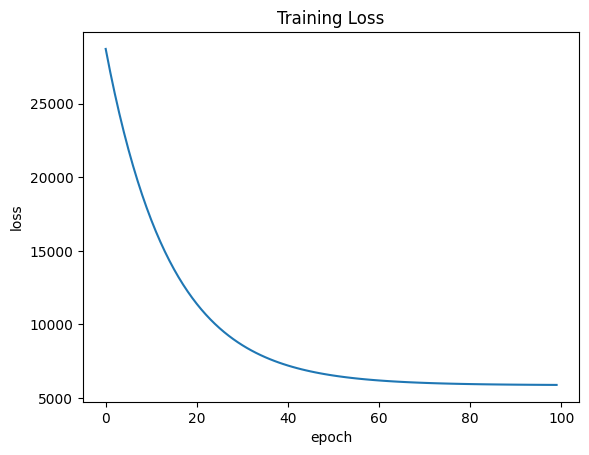

In [ ]:
#Plot training loss
plt.plot(range(epochs), train_losses)
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

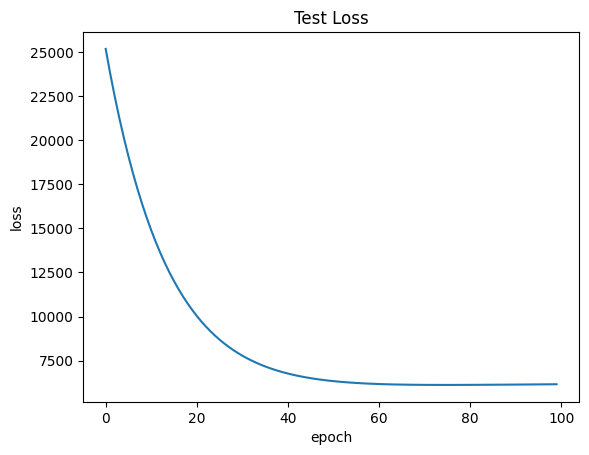

In [ ]:
#Plot test loss
plt.plot(range(epochs), test_losses)
plt.title("Test Loss")
plt.ylabel("loss")
plt.xlabel("epoch")

#Classification

Necessary installs & library imports

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.2/819.2 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 2.

In [ ]:
# Install
!pip install dotdict
!pip install ucimlrepo

  Preparing metadata (setup.py) ... done
  Created wheel for dotdict: filename=dotdict-0.1-py3-none-any.whl size=1624 sha256=e63a6cf988b6cc7438c157c767b64062e9c9bd3af851d1e7663c7ef5cc629678
  Stored in directory: /root/.cache/pip/wheels/66/a8/a1/56f81e629a2bb4b514c0ff9624a3e9931d74d27fe35aedfbac
Successfully built dotdict


In [ ]:
# Import
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from ucimlrepo import fetch_ucirepo

Define Neural Network

Structure:
9 hidden layers, fully connected, 50 nodes each, ReLU activation


> Additional code remains to document alternative testing strategies, such as increased depth (resulted in overfitting), batch normalization, and dropout, which didn't show significant improvements over baseline. Several optimizations attempted, including setting less and more hidden layers, adjusting node counts, setting different learning rates, epochs, etc.



In [ ]:
# Create model class for nn

nc = 50   # node count

class Model(nn.Module):
  def __init__(self,  in_features=34,
               h1=nc, h2=nc, h3=nc, h4=nc, h5=nc,
               h6=nc, h7=nc, h8=nc, h9=nc, #h10=nc,
               #h11=nc, h12=nc, h13=nc, h14=nc, h15=nc,
               #bNorm1=34,
               out_features=1):
    super().__init__() #instantiate nn.Module
    #self.bNorm1 = nn.BatchNorm1d(in_features, bNorm1, momentum=0.1)
    #self.fc1BNorm = nn.Linear(bNorm1, h1)
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.fc4 = nn.Linear(h3, h4)
    self.fc5 = nn.Linear(h4, h5)
    self.fc6 = nn.Linear(h5, h6)
    self.fc7 = nn.Linear(h6, h7)
    self.fc8 = nn.Linear(h7, h8)
    self.fc9 = nn.Linear(h8, h9)
    self.dropout = nn.Dropout(p=0.04)
    #self.fc10 = nn.Linear(h9, h10)
    #self.fc11 = nn.Linear(h10, h11)
    #self.fc12 = nn.Linear(h11, h12)
    #self.fc13 = nn.Linear(h12, h13)
    #self.fc14 = nn.Linear(h13, h14)
    #self.fc15 = nn.Linear(h14, h15)
    self.out = nn.Linear(h9, out_features)

  def forward(self, x):
    doDrop = False

    #x = F.relu(self.bNorm1(x))
    #x = F.relu(self.fc1BNorm(x))
    x = F.relu(self.fc1(x))
    if doDrop == True:
      x = self.dropout(x)

    x = F.relu(self.fc2(x))
    if doDrop == True:
      x = self.dropout(x)

    x = F.relu(self.fc3(x))
    if doDrop == True:
      x = self.dropout(x)

    x = F.relu(self.fc4(x))
    if doDrop == True:
      x = self.dropout(x)

    x = F.relu(self.fc5(x))
    if doDrop == True:
      x = self.dropout(x)

    x = F.relu(self.fc6(x))
    if doDrop == True:
      x = self.dropout(x)

    x = F.relu(self.fc7(x))
    if doDrop == True:
      x = self.dropout(x)

    x = F.relu(self.fc8(x))
    if doDrop == True:
      x = self.dropout(x)

    x = F.relu(self.fc9(x))
    if doDrop == True:
      x = self.dropout(x)

    x = self.out(x)

    return x

  def check(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = F.relu(self.fc7(x))
    x = F.relu(self.fc8(x))
    x = F.relu(self.fc9(x))
    x = self.out(x)
    return x


# Set random seed
torch.manual_seed(1337)

# Instantiate model
model = Model()

Prepare Data

In [ ]:
# fetch dataset
ionosphere = fetch_ucirepo(id=52)

# data (as pandas dataframes)
X = ionosphere.data.features
y = ionosphere.data.targets


# Preprocess data
  # Change values {g, b} in y to {1.0, 0.0}

y['Class'] = y['Class'].replace('g', 1.0)
y['Class'] = y['Class'].replace('b', 0.0)

# Convert to numpy arrays
X = X.values
y = y.values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

# Convert X features to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Convert y labels to tensors float
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

<ipython-input-27-7b690f8d1f9d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Class'] = y['Class'].replace('g', 1.0)
<ipython-input-27-7b690f8d1f9d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Class'] = y['Class'].replace('b', 0.0)


Train Classification model

In [ ]:
# Train model

# Error Criteria
criterion = nn.BCEWithLogitsLoss()

# Choose Optimizer, learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)    #Adam showed superior performance to AdamW
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)

# Set Epochs
epochs = 2100
losses = []
testLosses = []

y_pred = model.forward(X_train)
#print(y_pred)
#print(y_train.shape)
#print(y_pred.shape)
#loss = criterion(y_pred, y_train)
#print(f'Epoch: 1 with loss: {loss}')


for i in range(epochs):
  # Forward propagate
  y_pred = model.forward(X_train)

  # Determine loss
  loss = criterion(y_pred, y_train)

  # Track loss
  losses.append(loss.detach().numpy())

  # Print status every so often
  if i%(epochs/20) == 0 or i==epochs-1:
    print(f'Epoch: {i+1} with loss: {loss:0.5f}', end='')

  # Backpropagate
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Evaluate vs test
  model.eval()
  with torch.no_grad():
    y_eval = model.check(X_test)
    loss = criterion(y_eval, y_test)
    testLosses.append(loss.detach().numpy())
  model.train()

  if i%(epochs/20) == 0 or i==epochs-1:
    print(f'\t\ttest loss: {loss}')

Epoch: 1 with loss: 0.70362		test loss: 0.6975442171096802
Epoch: 106 with loss: 0.69806		test loss: 0.6951154470443726
Epoch: 211 with loss: 0.69293		test loss: 0.6929789185523987
Epoch: 316 with loss: 0.68760		test loss: 0.6908019185066223
Epoch: 421 with loss: 0.68152		test loss: 0.6874755620956421
Epoch: 526 with loss: 0.66350		test loss: 0.6726000308990479
Epoch: 631 with loss: 0.56951		test loss: 0.5921645760536194
Epoch: 736 with loss: 0.31383		test loss: 0.3827502429485321
Epoch: 841 with loss: 0.13906		test loss: 0.2237280160188675
Epoch: 946 with loss: 0.06510		test loss: 0.1520424634218216
Epoch: 1051 with loss: 0.04173		test loss: 0.132623553276062
Epoch: 1156 with loss: 0.03204		test loss: 0.11669768393039703
Epoch: 1261 with loss: 0.02683		test loss: 0.10037513077259064
Epoch: 1366 with loss: 0.02330		test loss: 0.08185882866382599
Epoch: 1471 with loss: 0.01899		test loss: 0.05579134449362755
Epoch: 1576 with loss: 0.01403		test loss: 0.0420365147292614
Epoch: 1681 with 

Plot loss across epochs

Text(0.5, 0, 'epoch')

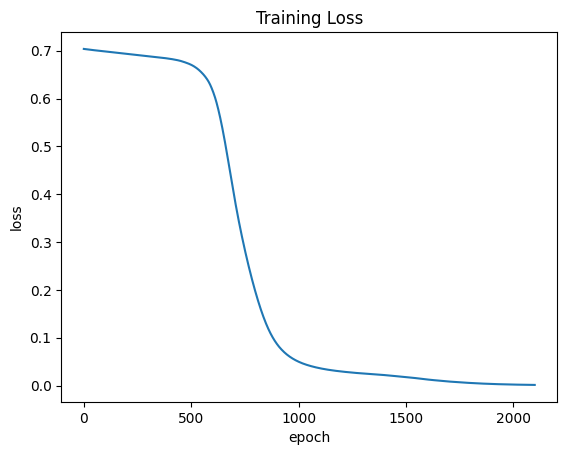

In [ ]:
#Plot training data
plt.plot(range(epochs), losses)
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

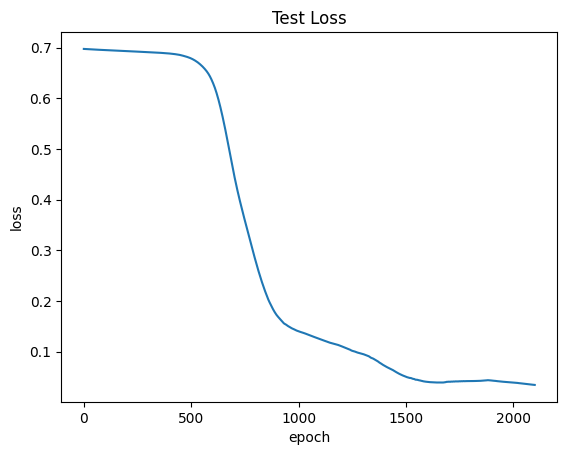

In [ ]:
#Plot testing data
plt.plot(range(epochs), testLosses)
plt.title("Test Loss")
plt.ylabel("loss")
plt.xlabel("epoch")

The following section generates a table of the model's performance on the test set.

What we really care about is if the sign of the result (+/-) matches the expected sign.

In [ ]:
correct = 0
with torch.no_grad():
  print(f'\tRESULT\t Expected  isCorrect?\n')
  isCorrect = ''
  expected = ''
  #print(f" value is {y_val.item()}")

  for i, data in enumerate(X_test):
    y_val = model.forward(data)

    if (y_val.item() >=0 and y_test[i].item() > 0.5) or (y_val.item() <0 and y_test[i].item() < 0.5):
      isCorrect = 'y'

    else:
      isCorrect = 'NO'
      expected = '-'

    if (y_test[i].item() > 0.5):
      expected = '+'

    else:
      expected = '-'

    # Print results
    #print(f'{i+1}. {y_val.item():0.2f} \t {y_test[i].item()} \t {isCorrect}')
    print(f'{i+1}.\t{y_val.item():0.2f}\t    {expected}\t   {isCorrect}')


	RESULT	 Expected  isCorrect?

1.	10.29	    +	   y
2.	-4.71	    -	   y
3.	7.55	    +	   y
4.	8.55	    +	   y
5.	8.09	    +	   y
6.	5.80	    +	   y
7.	-14.53	    -	   y
8.	10.84	    +	   y
9.	-13.24	    -	   y
10.	10.53	    +	   y
11.	8.75	    +	   y
12.	7.03	    +	   y
13.	-9.25	    -	   y
14.	-12.51	    -	   y
15.	-13.92	    -	   y
16.	-12.22	    -	   y
17.	13.84	    +	   y
18.	-10.88	    -	   y
19.	8.48	    +	   y
20.	10.30	    +	   y
21.	13.02	    +	   y
22.	10.30	    +	   y
23.	10.41	    +	   y
24.	-9.37	    -	   y
25.	12.58	    +	   y
26.	10.26	    +	   y
27.	-4.88	    -	   y
28.	4.40	    +	   y
29.	8.26	    +	   y
30.	-9.16	    -	   y
31.	11.35	    +	   y
32.	-10.58	    -	   y
33.	7.55	    +	   y
34.	-11.35	    -	   y
35.	-15.48	    -	   y
36.	-16.36	    -	   y
37.	11.77	    +	   y
38.	11.55	    +	   y
39.	-0.84	    +	   NO
40.	-15.56	    -	   y
41.	12.50	    +	   y
42.	10.52	    +	   y
43.	6.18	    +	   y
44.	11.90	    +	   y
45.	10.76	    +	   y
46.	-11.50	    -	   y
47.	-14.95

#Contributions
Jenny Zhao: 25%<br/><br/>
Abhinav Singh: 25%<br/><br/>
Shayan Darian: 25%<br/><br/>
Jeffrey Rhoten: 25%